In [6]:
import pandas as pd
import os
import io
from IPython.display import display
import cufflinks as cf
cf.go_offline()
import plotly.io as pio
import plotly.graph_objects as go
import requests
pio.renderers.default = 'colab'
df = pd.read_csv('../raw_data/extracted_from_reports/hospitalizations_per_province.csv', index_col=['date', 'province'], parse_dates=['date','report_date'])

In [7]:
df['date_lag'] = ((df['report_date'] - df.index.get_level_values(0)) / pd.Timedelta(days=1)).astype(int)

first_report = df[df['report_date'] == min(df['report_date'])]

MAX_DATE_LAG = 8

grouped_rows = df[df['date_lag'] >= MAX_DATE_LAG].groupby(level=[0,1]).max()
grouped_rows['date_lag'] = MAX_DATE_LAG


date_lags = pd.concat([df[df['date_lag'] < MAX_DATE_LAG], grouped_rows])

In [8]:
# plot total cases per day, by days lag in reporting
d = date_lags.pivot_table(index='date', columns='date_lag', values='value', aggfunc='sum')
d.loc[:'2020-03-28',:] = d.loc[:'2020-03-28',:].fillna(0)
d[-1] = 0.0
d = d[sorted(d.columns)].diff(axis=1)
d = d.drop(columns=-1).rename(columns={MAX_DATE_LAG:f"{MAX_DATE_LAG} or more"})
f = d.iplot(title="COVID Hospitalizations Netherlands by reporting lag", 
                            xTitle='date',  barmode='stack', 
                            kind='bar',colorscale='spectral', fill=True, interpolation='hv', 
                            asFigure=True, opacity=1)
f.layout['legend']['title'] = 'report lag<br>(# days later)'
f.layout['xaxis']['tickangle'] = 90
f.layout['xaxis']['dtick'] = 86400000
f.layout['xaxis']['tickformat'] = '%m-%d'

for bar in f.data:
    bar['marker']['line'].update({'width':0})
    
f.add_trace(go.Bar(
    x=[str(x) for x  in first_report.groupby('date').sum().index], 
    y=[str(y) for y in first_report.groupby('date').sum()['value']],
    orientation= 'v',
    marker= {'color': 'rgba(140, 140, 140, 1)', 'line': {'color': 'rgba(140, 140, 140, 1.0)', 'width': 0}},
    name='First report'
    ))

f.data = f.data[-1:] + f.data[:-1]


# add shades for weekends
for w in d.index[d.index.weekday == 5] - pd.Timedelta(days=0.5):
    w = go.layout.Shape(
        x0=str(w), x1=str(w+pd.Timedelta(days=2)), 
        y0=0, y1=1,
        layer='below', 
        yref='paper', xref='x',
        line={'width':0},
        fillcolor='#c6c5c5')
    f.add_shape(w)
    
    
with open(f.layout['title']['text'] + '.html', 'w') as fid:
    fid.write(f.to_html(include_plotlyjs='cdn'))
f

In [9]:
# needed to save plotly figures as png
!docker run -d --rm -p 9091:9091 quay.io/plotly/orca

39173c5968a44ceff5bbc62c547e579158c5a6a6410d736cb9c843d48936bfbd
docker: Error response from daemon: driver failed programming external connectivity on endpoint zealous_lovelace (845ad8cea56cd1342c57e93e05bd2715ec566b1d629da575081c9efa74a58901): Bind for 0.0.0.0:9091 failed: port is already allocated.


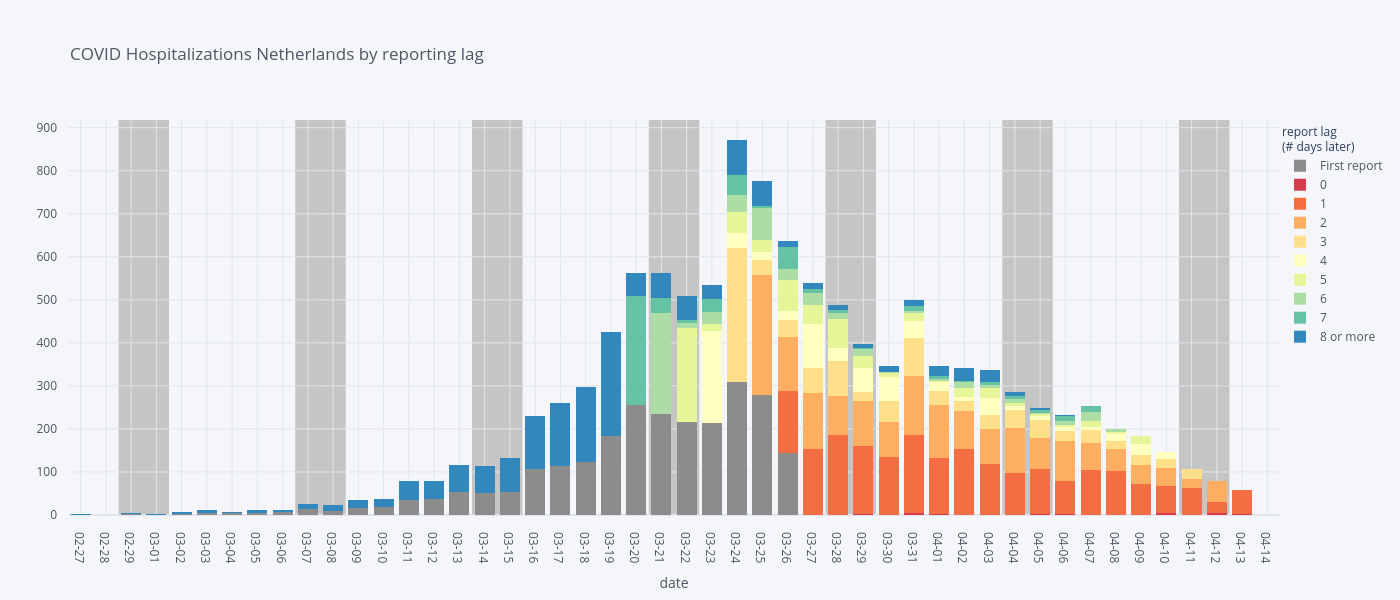

In [10]:
f.update_layout(legend=dict(x=1, y=1),
                margin=dict(
                    l=20,
                    r=120,
                    b=20,
                    t=120,
                    pad=10,
                    ),
                width=1400,
                height=600
                )

res = requests.post('http://localhost:9091', data=f.to_json())
from PIL import Image
im = Image.open(io.BytesIO(res.content))
im.save(f.layout['title']['text'] + '.png')
im